# Homework 3 - Data vizualisation

In [1]:
%matplotlib inline
import os
import pandas as pd
import json
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette("husl")

# Task 1 : European unemployment rates

### Load dataset
To begin, we download a dataset on the [Eurostat](http://ec.europa.eu/eurostat/data/database) website by using the search bar and looking for the term *Unemployment*. We have chosen the dataset called "Total umemployment rate" (*tsdec450*) that contains unemployment rates per year, for each european country.

In [2]:
total_unemployment_file_path = 'data/tsdec450.tsv'

# load the data
def load_data(file_name):
    df = pd.DataFrame()
    df = df.append( pd.read_csv(file_name, sep="\t" , header=0))
    df.columns = [i.split(" ")[0] for i in df.columns]
    df.columns = [i.split("\\")[0] for i in df.columns]
    new_col = df["age,unit,sex,geo"].str.split(",")
    df["State"] = [pi[3] for pi in new_col]
    df["Unit"] = [pi[1] for pi in new_col]
    
    return df

df = load_data(total_unemployment_file_path)
df.head()

,"age,unit,sex,geo",1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2009,2010,2011,2012,2013,2014,2015,2016,State,Unit
0,"TOTAL,PC_ACT,T,AT",:,:,:,:,4.3,4.2,4.7,4.7,4.7,...,5.3,4.8,4.6,4.9,5.4,5.6,5.7,6.0,AT,PC_ACT
1,"TOTAL,PC_ACT,T,BE",6.6,6.4,7.1,8.6,9.8,9.7,9.5,9.2,9.3,...,7.9,8.3,7.2,7.6,8.4,8.5,8.5,7.8,BE,PC_ACT
2,"TOTAL,PC_ACT,T,BG",:,:,:,:,:,:,:,:,:,...,6.8,10.3 i,11.3,12.3,13.0,11.4,9.2,7.6,BG,PC_ACT
3,"TOTAL,PC_ACT,T,CY",:,:,:,:,:,:,:,:,:,...,5.4,6.3,7.9,11.9,15.9,16.1,15.0,13.0,CY,PC_ACT
4,"TOTAL,PC_ACT,T,CZ",:,:,:,4.3,4.3,4.0,3.9,4.8,6.5,...,6.7,7.3,6.7,7.0,7.0,6.1,5.1,4.0,CZ,PC_ACT


In [3]:
#Pre-processing : keep only useful data
df['2016'] = df['2016'].astype(float)
df = df.query('Unit == \'PC_ACT\'')

# Put the same country code in the dataset and in json geo-coordinate files
df = df.replace('UK', 'GB')
df = df.replace('EL', 'GR')

### Define classification function
According to [GISGeography.com](http://gisgeography.com/choropleth-maps-data-classification/), we learn that selecting a data classification method is important in order to impact the reader. We decided to code and test two of them:
- **Equal Interval Data Classification** as *equal* : It divides the classes into equal groups of same interval length.
- **Quantile classification** as *quantile*: It arranges the classes to have the same quantity inside.

In [4]:
# define functions for classifying the unemployment
def define_threshold(df, column_name, classification='equal', classes=4):
    if classification == 'equal':
        min_val = df[column_name].min()
        max_val = df[column_name].max()
        bins = []
        bins.append(min_val - 0.001)
        for i in np.arange(1, classes):
            bins.append(((max_val - min_val)* i/classes) + min_val)
        bins.append(max_val + 0.001)
        return bins
    
    if classification == 'quantile':
        out, bins = pd.qcut(df[column_name], classes, retbins=True)
        return bins.tolist()

### Plot european map

In [5]:
geojson_path = 'topojson/europe.topojson.json'
topojson_path = json.load(open(geojson_path))

# Tip to not plot countries that were missing in the dataset
topojson_path['objects']['europe']['geometries'] = [feature for feature in topojson_path['objects']['europe']['geometries'] if (feature['id'] in df['State'].values)]

# Draw the map with our threshold classification function
eu_map = folium.Map([52.3, 9.7], tiles='cartodbpositron', zoom_start=3.6)
eu_map.choropleth(geo_data=topojson_path , data=df, topojson='objects.europe',
             columns=['State', '2016'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             threshold_scale=define_threshold(df, '2016', classification='quantile', classes=4),
             legend_name='Percentage of unemployment (%)')

eu_map
#eu_map.save('maps/unemployment_europe.html')

### Observations


In [6]:
#TODO Observations

# Task 2 : Swiss unemployment rates
We should apply the same methodology to display the unemployment rates in Switzerland. We start by loading the dataset from Amstat website.

## Assumptions
In order to have the swiss cantons codes to fill with our topojson file, we created a json file containing all cantos codes according to canton name. It will be used during the Tasks 2 and 3.

In [7]:
#TOPJSON FILE
switzerland_path = './topojson/ch-cantons.topojson.json'
switzerland_topojson_path = json.load(open(switzerland_path))

# OUR CANTON CODES FILE
switzerland_cantoncodes_path = 'data/swiss_cantons.json'
cantons = pd.read_json(switzerland_cantoncodes_path, encoding='utf-8')

## 2.1 - Unemployment rates

First, we decided to plot on the map the unemployement rate.

### Load dataset

In [8]:
#Load data
swiss_unemployed_filtered_path = 'data/unemployment.csv'
switzerland_unemployed_df = pd.read_csv(open(swiss_unemployed_filtered_path, encoding='utf-16'), header=[1,2], thousands='\'')

#Preprocessing
switzerland_unemployed_df = switzerland_unemployed_df[['Canton','Total']]
switzerland_unemployed_df.columns = ['canton', 'unemployment_rate', 'unemployed_jobseekers', 'all_jobseekers', 'employed_jobseekers']
switzerland_unemployed_df.drop(switzerland_unemployed_df.index[len(switzerland_unemployed_df)-1], inplace=True)

#cantons
cantons.drop(cantons.index[len(cantons)-1], inplace=True)
cantons.columns = ['code', 'canton']
switzerland_df = pd.merge(cantons,switzerland_unemployed_df, on=['canton'])
switzerland_df.head()

,code,canton,unemployment_rate,unemployed_jobseekers,all_jobseekers,employed_jobseekers
0,ZH,Zurich,3.7,361007,441431,80424
1,BE,Berne,2.7,183398,241011,57613
2,LU,Lucerne,2.1,55221,89599,34378
3,UR,Uri,1.0,2418,4361,1943
4,SZ,Schwyz,1.8,18446,27475,9029


### Plot Switzerland map

In [9]:
#TODO: Talk about choice of the colors

In [10]:
switzerland_map = folium.Map([46.8001, 8.1958], tiles='cartodbpositron', zoom_start=8)

switzerland_map.choropleth(geo_data=switzerland_topojson_path, data=switzerland_df, topojson='objects.cantons',
             columns=['code', 'unemployment_rate'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.6, line_opacity=0.2,
             legend_name='Unemployment rate (%)')


switzerland_map
switzerland_map.save('maps/unemployment_switzerland.html')

## 2.2 - Unemployment rates : various interpretations

### Compute new "unemployment" ratios

In [11]:
#TODO : Our assumptions

In [12]:
switzerland_df['population'] = (switzerland_df['all_jobseekers']/switzerland_df['unemployment_rate'])*100
switzerland_df['unemployed_jobseekers_unemployment_rate'] = (switzerland_df['unemployed_jobseekers']/switzerland_df['population'])*100
switzerland_df.head()

,code,canton,unemployment_rate,unemployed_jobseekers,all_jobseekers,employed_jobseekers,population,unemployed_jobseekers_unemployment_rate
0,ZH,Zurich,3.7,361007,441431,80424,1.193057e+07,3.025900
1,BE,Berne,2.7,183398,241011,57613,8.926333e+06,2.054573
2,LU,Lucerne,2.1,55221,89599,34378,4.266619e+06,1.294257
3,UR,Uri,1.0,2418,4361,1943,4.361000e+05,0.554460
4,SZ,Schwyz,1.8,18446,27475,9029,1.526389e+06,1.208473


### Plot swiss maps

In [13]:
#TODO : same scaling on each maps

In [14]:
switzerland_map = folium.Map([46.8001, 8.1958], tiles='cartodbpositron', zoom_start=8)

switzerland_map.choropleth(geo_data=switzerland_topojson_path, data=switzerland_df, topojson= 'objects.cantons',
             columns=['code', 'unemployment_rate'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment (%)')

switzerland_map
switzerland_map.save('maps/unemployment_switzerland_all_jobseekers.html')

In [15]:
switzerland_map = folium.Map([46.8001, 8.1958], tiles='cartodbpositron', zoom_start=8)

switzerland_map.choropleth(geo_data=switzerland_topojson_path, data=switzerland_df, topojson= 'objects.cantons',
             columns=['code', 'unemployed_jobseekers_unemployment_rate'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment (%)')

switzerland_map
switzerland_map.save('maps/unemployment_switzerland_unemployed_jobseekers.html')

## Analysis : include employed jobseekers or not ?
Here, we will discuss on the different interpretations of "unemployement rate".

In [16]:
# TODO: discussion

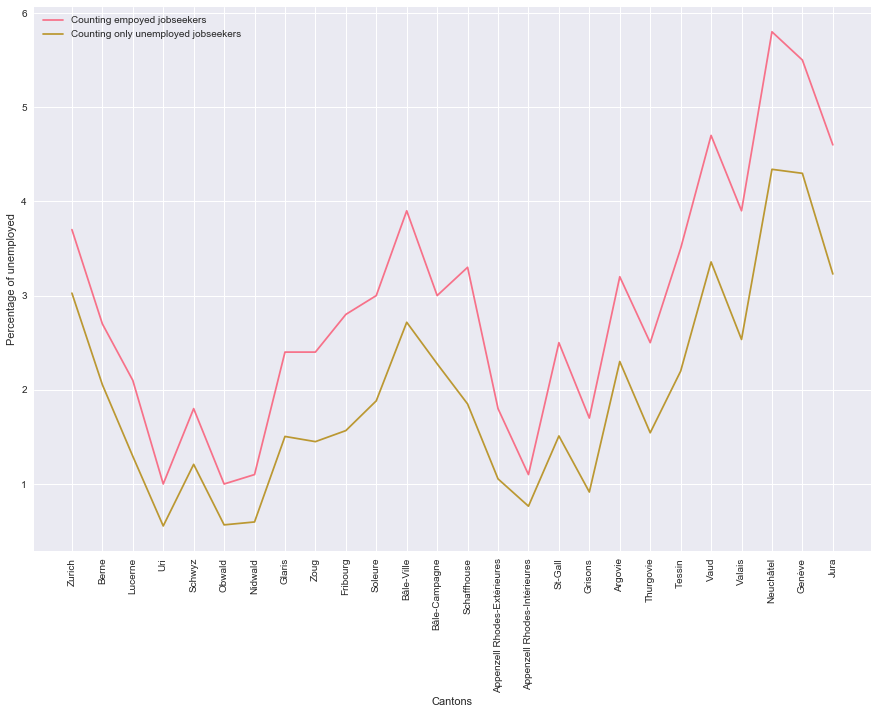

In [17]:
sns.axes_style("darkgrid")
fig, ax = plt.subplots(figsize=(15,10))
x = [i for i in np.arange(0, len(switzerland_df))]
ax.plot(x, switzerland_df.unemployment_rate)
ax.plot(x, switzerland_df.unemployed_jobseekers_unemployment_rate)
ax.set_ylabel("Percentage of unemployed")
ax.set_xlabel("Cantons")
plt.xticks(x, switzerland_df['canton'], rotation='vertical')
ax.legend(["Counting empoyed jobseekers", "Counting only unemployed jobseekers"])

# Task 3 : Swiss unemployment data with additional attributes

In this task we also decided to take the previous year into account : 2016

### 3.1 - Nationality
We find on amstat website a dataset that contains unemployment rates for each canton, according to the nationality of the jobseekers. We distinguished two classes:
- Swiss people
- Foreign people

In [18]:
switzerland_nationality_path = 'data/unemployment_nationality.csv'
switzerland_nationality_df = pd.read_csv(open(switzerland_nationality_path, encoding='utf-16'), header=[1,2], thousands='\'')
switzerland_nationality_df = switzerland_nationality_df[['Canton','Nationalité' ,'Total']]
switzerland_nationality_df.columns = ['canton', 'nationality', 'unemployment_rate', 'employed_jobseekers', 'all_jobseekers', 'unemployed_jobseekers']
switzerland_nationality_df.head()

,canton,nationality,unemployment_rate,employed_jobseekers,all_jobseekers,unemployed_jobseekers
0,Zurich,Etrangers,6.0,164436,202818,38382
1,Zurich,Suisses,2.8,196571,238613,42042
2,Berne,Etrangers,6.5,69502,93346,23844
3,Berne,Suisses,2.0,113896,147665,33769
4,Lucerne,Etrangers,4.7,22927,39061,16134


In [19]:
switzerland_all_nationality_df = pd.merge(cantons,switzerland_nationality_df, on=['canton'])

# Split dataframe by nationality attribute
switzerland_strangers_df = switzerland_all_nationality_df.query('nationality == \'Etrangers\'') 
switzerland_suisses_df = switzerland_all_nationality_df.query('nationality == \'Suisses\'') 

switzerland_suisses_df.reset_index(inplace=True)
switzerland_strangers_df.reset_index(inplace=True)

#Swiss people dataframe
switzerland_suisses_df.head()

,index,code,canton,nationality,unemployment_rate,employed_jobseekers,all_jobseekers,unemployed_jobseekers
0,1,ZH,Zurich,Suisses,2.8,196571,238613,42042
1,3,BE,Berne,Suisses,2.0,113896,147665,33769
2,5,LU,Lucerne,Suisses,1.5,32294,50538,18244
3,7,UR,Uri,Suisses,0.6,1140,2091,951
4,9,SZ,Schwyz,Suisses,1.2,9999,14425,4426


In [20]:
#Foreign people dataframe
switzerland_strangers_df.head()

,index,code,canton,nationality,unemployment_rate,employed_jobseekers,all_jobseekers,unemployed_jobseekers
0,0,ZH,Zurich,Etrangers,6.0,164436,202818,38382
1,2,BE,Berne,Etrangers,6.5,69502,93346,23844
2,4,LU,Lucerne,Etrangers,4.7,22927,39061,16134
3,6,UR,Uri,Etrangers,4.2,1278,2270,992
4,8,SZ,Schwyz,Etrangers,3.9,8447,13050,4603


## Map of unemployment rate - difference between swiss and foreigners



On the map we show difference between the unemployment rate between swiss people and foregners. We notice that this difference is biggest in the next regions: ...

In [21]:
#Layer Control add to see both maps in one
m_switzerland_swiss_foreigners = folium.Map([46.8001, 8.1958], tiles='cartodbpositron', zoom_start=8)

m_switzerland_swiss_foreigners.choropleth(geo_data=switzerland_topojson_path, data=switzerland_suisses_df,
             columns=['code', 'unemployment_rate'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.3, line_opacity=0.2,
             legend_name='Unemployment rate - Swiss population (%)',
             name='Unemployment rates - Swiss population',
             topojson='objects.cantons')

m_switzerland_swiss_foreigners.choropleth(geo_data=switzerland_topojson_path, data=switzerland_strangers_df,
             columns=['code', 'unemployment_rate'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.3, line_opacity=0.2,
             legend_name='Unemployment rate - Foreign population (%)', 
             name='Unemployment rates - Foreign population',
             topojson='objects.cantons')

folium.LayerControl(collapsed=False).add_to(m_switzerland_swiss_foreigners)

m_switzerland_swiss_foreigners
m_switzerland_swiss_foreigners.save('maps/unemployment_switzerland_swiss_foreigners.html')

In [22]:
# TODO: Do a bar plot to see distribution between swiss and foreigners

### 3.2 - Nationality and age groups

Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

#### Assumptions
We don't achieve to get unemployment rates for all classes (age and nationality).<br>
As a matter of fact, we decided to show the distribution between all the subclasses using one final horizontal barplot.

In [23]:
def define_age_classes(x):
    if(x == '1'):
        return ' 15 - 24 years'
    elif(x == '2'):
        return ' 25 - 49 years'
    else:
        return ' 50+ years'

In [24]:
switzerland_age_groups_path = 'data/unemployment_nationality_age.csv'

#Some preprocessing 
switzerland_age_df = pd.read_csv(open(switzerland_age_groups_path, encoding='utf-16'), header=[1,2], thousands='\'')
switzerland_age_df = switzerland_age_df[~switzerland_age_df.isin(['Total'])] #Remove total rows : useless for us
switzerland_age_df = switzerland_age_df.drop(['Mesures', 'Unnamed: 3_level_1'], axis=1, level=1).dropna()
switzerland_age_df.rename(columns={'Classes d\'âge 15-24, 25-49, 50 ans et plus': 'classes', }, inplace=True)
switzerland_age_df.columns = switzerland_age_df.columns.droplevel(1)
switzerland_age_df['Total'] = np.round(switzerland_age_df.mean(axis=1).astype('int64'))
switzerland_age_df['classes'] = switzerland_age_df['classes'].apply(lambda x: define_age_classes(x))
switzerland_age_df['Nationality + age'] = switzerland_age_df['Nationalité'] + ' ' + switzerland_age_df['classes']

# Use pivot function for horizontal bar plot
switzerland_age_df = switzerland_age_df.pivot(index='Canton', columns='Nationality + age', values='Total')
switzerland_age_df

Nationality + age,Etrangers 15 - 24 years,Etrangers 25 - 49 years,Etrangers 50+ years,Suisses 15 - 24 years,Suisses 25 - 49 years,Suisses 50+ years
Canton,,,,,,
Appenzell Rhodes-Extérieures,29,231,95,89,262,244
Appenzell Rhodes-Intérieures,7,35,18,12,33,34
Argovie,797,5316,1625,1166,4139,2929
Berne,679,5455,1644,1872,6287,4145
Bâle-Campagne,194,1727,543,416,1782,1195
Bâle-Ville,224,2117,597,352,1482,728
Fribourg,421,2832,761,590,2350,1342
Genève,471,6381,1547,817,5347,2028
Glaris,49,290,120,62,179,145


### Analysis on the distribution

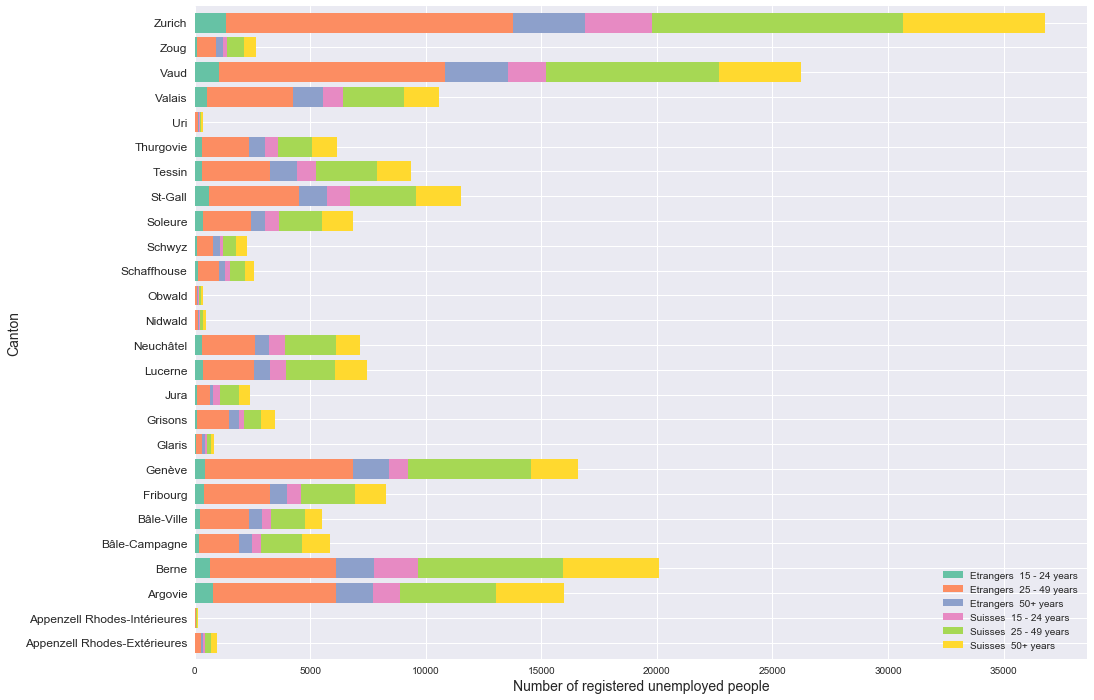

In [25]:
sns.set_palette("Set2")
fig, ax = plt.subplots(figsize=(16,12))
switzerland_age_df.plot.barh(stacked=True, grid=True, width=0.8, ax=ax)
plt.xlabel('Number of registered unemployed people',fontsize=14)
plt.ylabel('Canton', fontsize=14)
plt.yticks(fontsize=12)
plt.legend()

#### Observations
TODO

# Bonus part : Röstigraben

Using the map you have just built, and the geographical information contained in it, could you give a rough estimate of the difference in unemployment rates between the areas divided by the Röstigraben?

## Methodology

In order to see nicely the three Rostigraben groups on the map, we plot cantons with different bording colors, according if people speak French, Deutch or Italian.

In [26]:
def rostigraben_colors(feature_id):
    IT = ['TI']
    FR = ['GE', 'VD', 'FR', 'NE', 'VS', 'JU']
    
    if feature_id in IT:
            return '#4daf4a';
    elif feature_id in FR:
        return '#377eb8'
    else:
        return '#e41a1c'

In [27]:
rostigraben_map = folium.Map([46.8001, 8.1958], tiles='cartodbpositron', zoom_start=8)

# Layer 1: unemployment rate for swiss people
rostigraben_map.choropleth(geo_data=switzerland_topojson_path, data=switzerland_suisses_df,
             columns=['code', 'unemployment_rate'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.3, line_opacity=0,
             legend_name='Unemployment rate - Swiss population (%)',
             name='Unemployment rates - Swiss population',
             topojson='objects.cantons', threshold_scale=define_threshold(switzerland_suisses_df, 'unemployment_rate', 'equal', 5))

# Layer 2: unemployment rate for foreign people
rostigraben_map.choropleth(geo_data=switzerland_topojson_path, data=switzerland_strangers_df,
             columns=['code', 'unemployment_rate'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.3, line_opacity=0,
             legend_name='Unemployment rate - Foreign population (%)', 
             name='Unemployment rates - Foreign population',
             topojson='objects.cantons', threshold_scale=define_threshold(switzerland_strangers_df, 'unemployment_rate', 'equal', 5))

# Layer 3: cantons borders according to rostigraben regions
folium.TopoJson(
    switzerland_topojson_path,
    name = 'Languages spoken according to Rostigraben',
    object_path ='objects.cantons',
    style_function=lambda feature: {
        'fill_color': 'white',
        'fillOpacity': 0,
        'weight' : 3,
        'color': rostigraben_colors(feature['id']),
        'opacity': 1
        
    }
).add_to(rostigraben_map)

folium.LayerControl(collapsed=False).add_to(rostigraben_map)

## Final results

### 1 - Map

In [28]:
rostigraben_map
rostigraben_map.save('maps/unemployment_switzerland_rostigraben.html')

### 2 - Statistics data

In [29]:
# TODO : nice array or graph to show mean and variance of unemployement rates between rostigraben regions

## Observations